## Hypotheses

In [1]:
!pip install statsmodels==0.13.5

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

Correlation coefficient between population density and confirmed cases: 0.21037154624992097


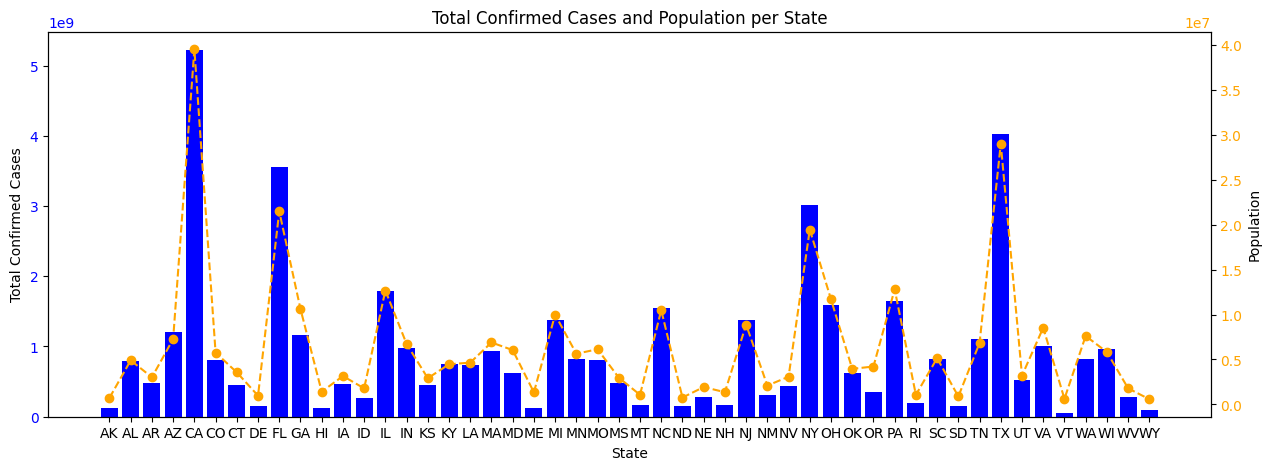

In [3]:
confirmed_cases = pd.read_csv('data/covid_confirmed_usafacts.csv')
pop_for_us = pd.read_csv('data/covid_county_population_usafacts.csv', usecols= ['countyFIPS', 'population'])
state_areas = pd.read_csv('state-areas.csv')


state_abbr = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

state_areas['State Abbreviation'] = state_areas['state'].map(state_abbr)

covid_data = pd.merge(confirmed_cases, pop_for_us, on= 'countyFIPS', suffixes="_cases")
covid_data.drop(covid_data[covid_data["County Name"].str.contains("Statewide")==True].index, inplace=True)
state_pop = covid_data.groupby('State').sum()['population']
covid_data = covid_data.groupby('State')[list(covid_data.columns[4:])].sum().reset_index()
covid_data['cases_total'] = covid_data.iloc[:, 1:-1].sum(axis=1)

state_cases = covid_data.merge(state_areas, left_on='State', right_on='State Abbreviation')
state_cases.drop('State Abbreviation', axis=1, inplace=True)
state_cases.drop('state', axis=1, inplace=True)

state_cases['density'] = state_cases['population'] / state_cases["area (sq. mi)"]

state_data = state_cases.groupby("State").agg({"population": "sum", "density": "mean", "cases_total":"sum"})

correlation = state_data["density"].corr(state_data["cases_total"])

print("Correlation coefficient between population density and confirmed cases:", correlation)

fig, ax1 = plt.subplots(figsize=(15, 5))

# plot total confirmed cases on primary y-axis
ax1.bar(state_data.index, state_data['cases_total'], color='blue')
ax1.set_xlabel('State')
ax1.set_ylabel('Total Confirmed Cases')
ax1.tick_params(axis='y', labelcolor='blue')

# create a secondary y-axis for population
ax2 = ax1.twinx()
ax2.plot(state_data.index, state_data['population'], color='orange', marker='o', linestyle='dashed')
ax2.set_ylabel('Population')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Total Confirmed Cases and Population per State')
plt.show()


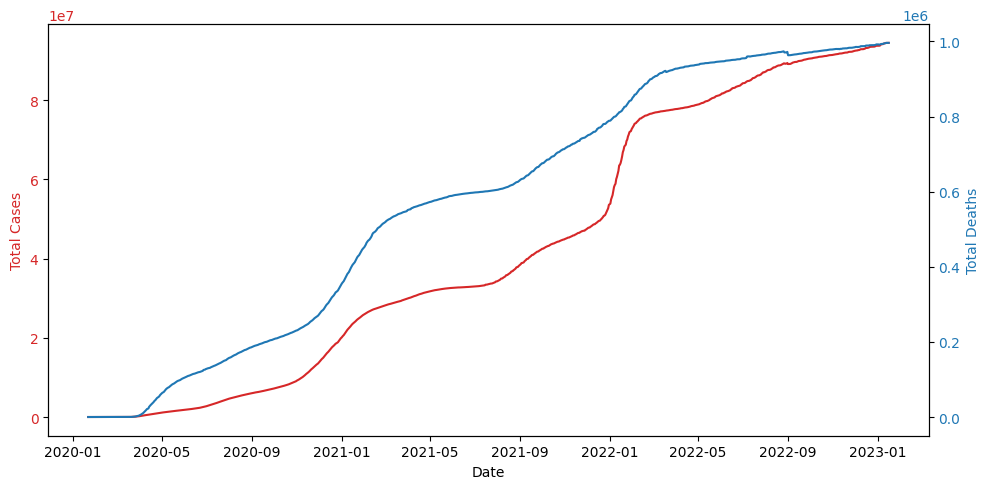

In [4]:
cases_data = pd.read_csv('data/covid_confirmed_usafacts.csv')
cases_data.drop(cases_data[cases_data["County Name"].str.contains("Statewide")==True].index, inplace=True)
cases_data = cases_data.iloc[:, 4:].sum(axis=0).reset_index()

deaths_data = pd.read_csv('data/covid_deaths_usafacts.csv')
deaths_data.drop(deaths_data[deaths_data["County Name"].str.contains("Statewide")==True].index, inplace=True)
deaths_data = deaths_data.iloc[:, 4:].sum(axis=0).reset_index()

# Rename the columns
cases_data.columns = ['date', 'total_cases']
deaths_data.columns = ['date', 'total_deaths']

# Convert the date column to a datetime object
cases_data['date'] = pd.to_datetime(cases_data['date'])
deaths_data['date'] = pd.to_datetime(deaths_data['date'])

fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases', color=color)
ax1.plot(cases_data['date'], cases_data['total_cases'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Total Deaths', color=color)
ax2.plot(deaths_data['date'], deaths_data['total_deaths'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()



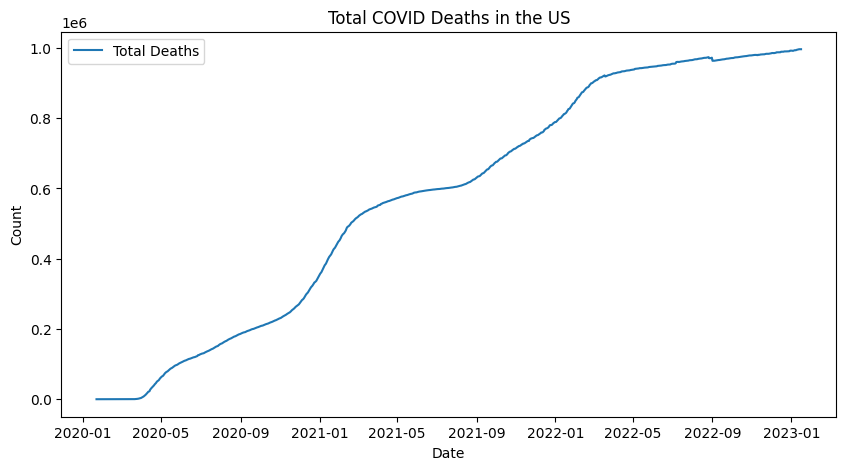

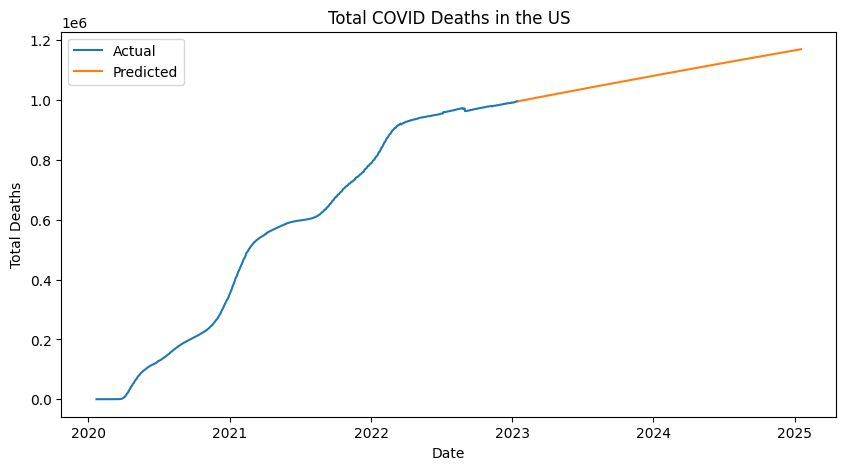

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(deaths_data['date'], deaths_data['total_deaths'], label='Total Deaths')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Total COVID Deaths in the US')
ax.legend()
plt.show()

model = ARIMA(deaths_data['total_deaths'], order=(2, 1, 2))
model_fit = model.fit()

start_date = deaths_data['date'].max() + pd.DateOffset(days=1)
end_date = start_date + pd.DateOffset(years=1)
future_dates = pd.date_range(start_date, end_date, freq='D')
forecast = model_fit.forecast(steps=len(future_dates))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(deaths_data['date'], deaths_data['total_deaths'], label='Actual')
ax.plot(future_dates, forecast, label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Total Deaths')
ax.set_title('Total COVID Deaths in the US')
ax.legend()
plt.show()



### Comparing the U.S. to other Countries

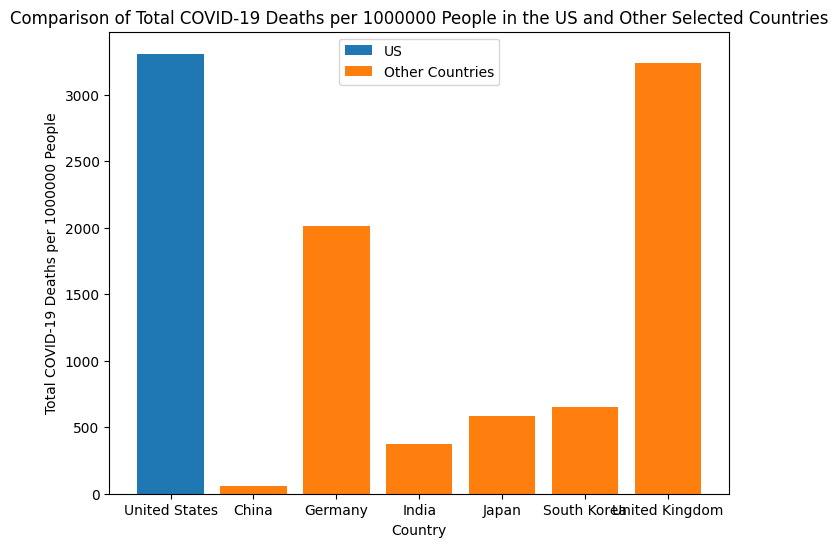

In [6]:
world_df = pd.read_csv("data/owid-covid-data-cases.csv", usecols=['location','date','total_cases','new_cases','total_deaths','new_deaths','population'])
world_df = world_df.fillna(0) #fill our NaN values to zero.

FACTOR = 1000000

us_covid_data = world_df[world_df['location'] == 'United States']
other_countries_covid_data = world_df[world_df['location'].isin(['China', 'India', 'Japan', 'Germany', 'United Kingdom', 'South Korea'])]

# Calculate the statistics per million population
us_covid_data['total_cases_per_million'] = us_covid_data['total_cases'] / (us_covid_data['population'] / FACTOR)
us_covid_data['new_cases_per_million'] = us_covid_data['new_cases'] / (us_covid_data['population'] / FACTOR)
us_covid_data['total_deaths_per_million'] = us_covid_data['total_deaths'] / (us_covid_data['population'] / FACTOR)
us_covid_data['new_deaths_per_million'] = us_covid_data['new_deaths'] / (us_covid_data['population'] / FACTOR)

other_countries_covid_data['total_cases_per_million'] = other_countries_covid_data['total_cases'] / (other_countries_covid_data['population'] / FACTOR)
other_countries_covid_data['new_cases_per_million'] = other_countries_covid_data['new_cases'] / (other_countries_covid_data['population'] / FACTOR)
other_countries_covid_data['total_deaths_per_million'] = other_countries_covid_data['total_deaths'] / (other_countries_covid_data['population'] / FACTOR)
other_countries_covid_data['new_deaths_per_million'] = other_countries_covid_data['new_deaths'] / (other_countries_covid_data['population'] / FACTOR)

fig, ax = plt.subplots(figsize=(8,6))

ax.bar(us_covid_data['location'], us_covid_data['total_deaths_per_million'], label='US')
ax.bar(other_countries_covid_data['location'], other_countries_covid_data['total_deaths_per_million'], label='Other Countries')

ax.set_xlabel('Country')
ax.set_ylabel(f'Total COVID-19 Deaths per {FACTOR} People')
ax.set_title(f"Comparison of Total COVID-19 Deaths per {FACTOR} People in the US and Other Selected Countries")
ax.legend()

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0e0e3b7b-f33d-441b-9ff5-010eb7be2d8b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>